#  Trabajo Practico 2

    integrantes: Alvarez Vico Jazmín LU: 75/15
                 Cortés Conde Titó Javier LU: 252/15
                 Frassia Fernando Nicolás LU: 340/13
                 

# Introducción

Para el trabajo práctico 2, se nos propuso trabajar con electroencefalogramas de pacientes en estado de coma, y ver qué información podíamos extraer de los mismos. Dichos pacientes se clasificaron en dos grupos, aquellos que presentaban actividad cerebral normal y aquellos que no.

El primer problema - y he aquí el objetivo del trabajo - era que los volúmenes de datos eran demasiado grandes (aproximadamente 300 MB por paciente), por lo que tuvimos que tomar algunas decisiones con respecto a donde poner el foco del trabajo. La cantidad de datos que fuimos analizando fue variable con respecto a la granularidad de la tarea a realizar; por ejemplo a veces tomamos 5 electrodos en particular de un paciente, y otras veces tomamos todos los pacientes con todos sus electrodos. Esto nos hace reflexionar acerca de cómo comparar los distintos análisis entre sí, y que los resultados que muestran están íntimamente relacionados a la cantidad de datos que analizan. Por otro lado, creemos que es un problema común en los trabajos relacionados a la ciencia de datos, por lo que estamos satisfechos de habernos encontrado con dichos problemas aquí.



## Aclaración:
### Para poder correr este notebook, se necesitan dos carpetas "matricesP" y "matricesS", en cada una de ellas se almacenan las matrices correspondientes.

## Funciones auxiliares


In [143]:
import scipy as sp
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy.signal import welch
import scipy.io
import os
from math import log
log2= lambda x:log(x,2)
from collections import defaultdict

def distribucion_normal(l1):
    return sp.stats.shapiro(l1)[1] >=0.05

def igual_varianza(l1,l2):
    estadistico = np.var(l1) / np.var(l2) 
    pval=  sp.stats.f.cdf(estadistico,len(l1)-1, len(l2)-1)
    #print("pval = " + str(pval))
    return pval>=0.05

def  wilcoxon_apareadas(l1,l2):
    pval= sp.stats.wilcoxon(l1,l2)[1]
    print("p value = " + str(pval))
    
def igual_media_apareada(l1,l2): 
    if distribucion_normal(l1) and distribucion_normal(l2):
        print("checkeo distribución normal: No concluyente, suponemos normalidad")
        ig_var = igual_varianza(l1,l2)
        ig_var2 = igual_varianza(l2,l1)
        if (ig_var and ig_var2):            
            print("checkeo varianza: No concluyente, suponemos igual varianza")
            print("utilizamos test de Student")
            pval = sp.stats.ttest_rel(l1, l2)[1]
            print("p value = " + str(pval) )
        else:
            print("checkeo varianza: NO")
            print("utilizamos test de Welsh")
            pval = sp.stats.ttest_ind(l1, l2)[1]
            print("p value = " + str(pval) )
            
    print("utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal")
    wilcoxon_apareadas(l1,l2)

def distribucion_normal(l1):
    return sp.stats.shapiro(l1)[1] >=0.05

def igual_media_1muestra(l):
    if distribucion_normal(l):
        print("checkeo distribución normal: ok") 
        meanl = np.mean(l)
        pval = sp.stats.ttest_1samp(l,meanl)[1]
        print("p value = " + str(pval) )
        

def promediar_epoch(sujeto, electrodo):
    df = pd.DataFrame(sujeto[:,electrodo-1,:])
    df_Media = df.mean(axis=0)
    return df_Media

def promediar_epoch_electrodo(sujeto):
    df8_Media = promediar_epoch(sujeto, 8)
    df44_Media = promediar_epoch(sujeto, 44)
    df80_Media = promediar_epoch(sujeto, 80)
    df131_Media = promediar_epoch(sujeto, 131)
    df185_Media = promediar_epoch(sujeto, 185)
    
    promedio_electrodos = (df8_Media + df44_Media + df80_Media + df131_Media + df185_Media)/5

    return promedio_electrodos 

def calcular_bandas(lista_sujetos, cantidad_electrodos, normalizado, index):
    #calculamos las potencias, ya que no utilizamos los valores generales.
    df_pot = pd.DataFrame()
    df_alphas = pd.DataFrame()
    df_betas = pd.DataFrame()
    df_thetas = pd.DataFrame()
    df_deltas = pd.DataFrame()
    df_gamas = pd.DataFrame()

    i=1
    for sujeto in lista_sujetos:

        potencias_media = []
        for count in range(cantidad_electrodos):
            welch = sp.signal.welch(sujeto[:,count,:], noverlap=100, fs=250, nperseg = 201)
            frecuencias = welch[0][:index]
            potencias = welch[1][:, :index]
            promedio_potencias = potencias.mean(axis=0)
            potencias_media.append(promedio_potencias)

        potencias_media = np.array(potencias_media)
        medias = potencias_media.mean(axis=0)

        index_delta = (np.abs(frecuencias-4)).argmin()
        delta = medias[:index_delta]
        df_deltas['sujeto'+str(i)] = delta

        index_theta = (np.abs(frecuencias-8)).argmin()
        theta= medias[index_delta+1:index_theta]
        df_thetas['sujeto'+str(i)] = theta

        index_alpha = (np.abs(frecuencias-13)).argmin()
        alpha = medias[index_theta+1:index_alpha]
        df_alphas['sujeto'+str(i)] = alpha

        index_beta = (np.abs(frecuencias-30)).argmin()
        beta = medias[index_alpha+1:index_beta]
        df_betas['sujeto'+str(i)] = beta

        gama = medias[index_beta+1:]
        df_gamas['sujeto'+str(i)] = gama
        i+=1
    if normalizado:
        df_pot['delta'] = df_deltas.sum() / len(df_deltas)
        df_pot['theta'] = df_thetas.sum() / len(df_thetas)
        df_pot['alpha'] = df_alphas.sum() / len(df_alphas)
        df_pot['beta'] = df_betas.sum() / len(df_betas)
        df_pot['gama'] = df_gamas.sum() / len(df_gamas)
    else:
        df_pot['delta'] = df_deltas.sum() 
        df_pot['theta'] = df_thetas.sum() 
        df_pot['alpha'] = df_alphas.sum() 
        df_pot['beta'] = df_betas.sum()
        df_pot['gama'] = df_gamas.sum()
    
    return df_pot

def tomar_banda(lista_sujetos, banda, index):
    df_alphas = pd.DataFrame()
    df_betas = pd.DataFrame()
    df_thetas = pd.DataFrame()
    df_deltas = pd.DataFrame()
    df_gamas = pd.DataFrame()

    i=1
    for sujeto in lista_sujetos:

        potencias_media = []
        for count in range(cantidad_electrodos):
            welch = sp.signal.welch(sujeto[:,count,:], noverlap=100, fs=250, nperseg = 201)
            frecuencias = welch[0][:index]
            potencias = welch[1][:, :index]
            promedio_potencias = potencias.mean(axis=0)
            potencias_media.append(promedio_potencias)

        potencias_media = np.array(potencias_media)
        medias = potencias_media.mean(axis=0)

        index_delta = (np.abs(frecuencias-4)).argmin()
        delta = medias[:index_delta]
        df_deltas['sujeto'+str(i)] = delta

        index_theta = (np.abs(frecuencias-8)).argmin()
        theta= medias[index_delta+1:index_theta]
        df_thetas['sujeto'+str(i)] = theta

        index_alpha = (np.abs(frecuencias-13)).argmin()
        alpha = medias[index_theta+1:index_alpha]
        df_alphas['sujeto'+str(i)] = alpha

        index_beta = (np.abs(frecuencias-30)).argmin()
        beta = medias[index_alpha+1:index_beta]
        df_betas['sujeto'+str(i)] = beta

        gama = medias[index_beta+1:]
        df_gamas['sujeto'+str(i)] = gama
        i+=1
    
    if banda == 'alpha':
        return df_alphas
    elif banda == 'gama':
        return df_gamas
    elif banda == 'delta':
        return df_deltas
    elif banda == 'beta':
        return df_betas
    elif banda == 'theta':
        return df_thetas
    else:
        print("escribiste mal la banda")

## Lectura de datos

los datos vienen en la forma de un tensor de tres dimensiones: epoch X Electrodo X serie temporal

In [144]:
lista_sujetosP = []
matrices = os.listdir('./matricesP/')
for mat in matrices:
    m = sp.io.loadmat('./matricesP/' + mat)
    mm = m['data']
    lista_sujetosP.append(mm)
    
       

lista_sujetosS = []
matrices = os.listdir('./matricesS/')
for mat in matrices:
    m = sp.io.loadmat('./matricesS/' + mat)
    mm = m['data']
    lista_sujetosS.append(mm)


Realizamos el promedio de las series temporales

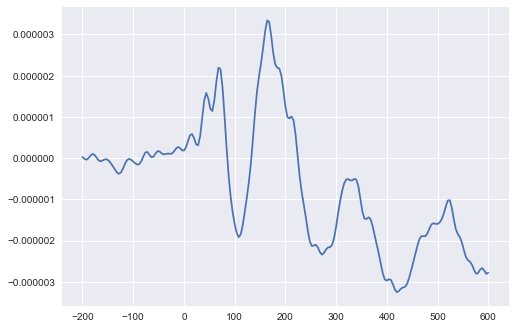

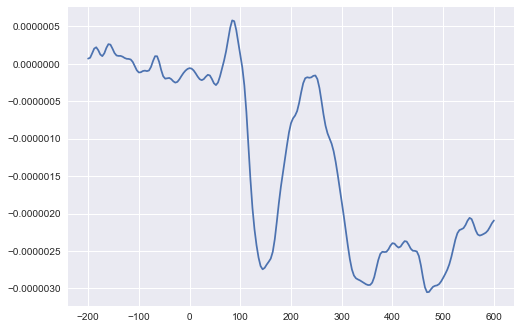

In [145]:
#promedio de serie temporal x epoch. (matriz de 1 epoch con la serie promediada.)
S_df8_Media = promediar_epoch(lista_sujetosS[0], 8)

plt.plot(np.linspace(-200, 600, 201), S_df8_Media)
plt.show()

P_df8_Media = promediar_epoch(lista_sujetosP[0], 8)
plt.plot(np.linspace(-200, 600, 201), P_df8_Media)
plt.show()

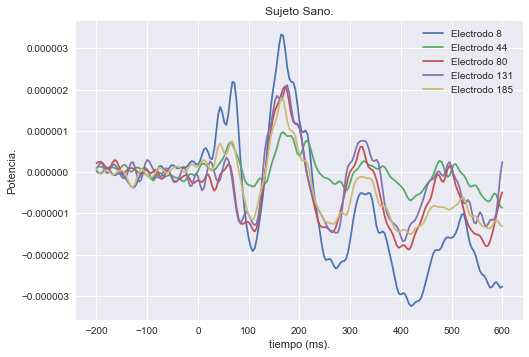

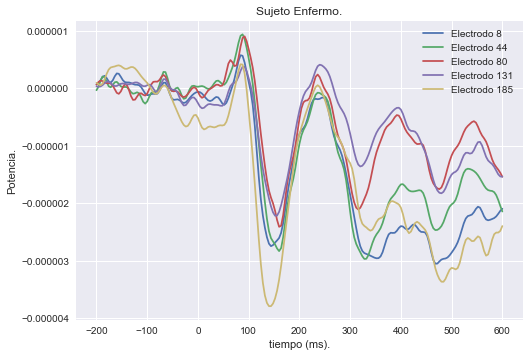

In [146]:

#epoch X serie temporal

def graficar_promedio_epoch(sujeto, enfermo, lista_electrodos):
    for i in lista_electrodos:
        Media = promediar_epoch(sujeto, i)
        plt.plot(np.linspace(-200, 600, 201), Media, label = "Electrodo "+str(i))
    plt.ylabel("Potencia.")
    plt.xlabel("tiempo (ms).")
    if enfermo:
        plt.title("Sujeto Enfermo.")
    else:
        plt.title("Sujeto Sano.")
    plt.legend()
    plt.show()

graficar_promedio_epoch(lista_sujetosS[0], False, [8, 44, 80, 131, 185])

graficar_promedio_epoch(lista_sujetosP[0], True, [8, 44, 80, 131, 185])


# 2.1) Analisis de frecuencia



La frecuencia es una magnitud que mide el número de repeticiones por unidad de tiempo de cualquier fenómeno o suceso periódico. 
Es decir, podemos medir las ocurrencias de algun fenómeno utilizando el epoch y la serie temporal asociada al mismo. 


El espectrograma es una representación en tres dimensiones (temporal, frecuencial y amplitud) de la distribución de energía de una señal.
Podemos considerarlo como proyección bidimensional de estas tres dimensiones. En este caso representamos en el eje x los epochs (dimensión temporal), en el eje y la frecuencia (dimensión frecuencial) y con una escala de colores representamos la potencia (dimensión de amplitud).

Al realizar FFT, podemos extraer esta información de nuestros datos para mostrarla en el espectrograma.

En esta ocasión realizaremos el analisis de frecuencia para dos sujetos, uno en estado vegetativo, y el otro en condiciones normales.

a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color.

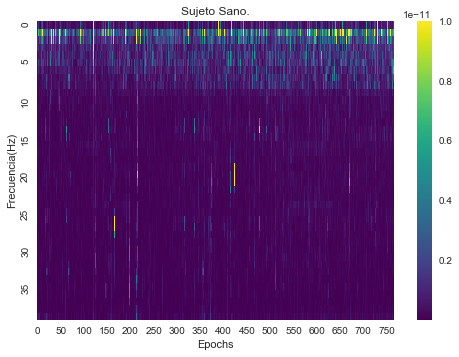

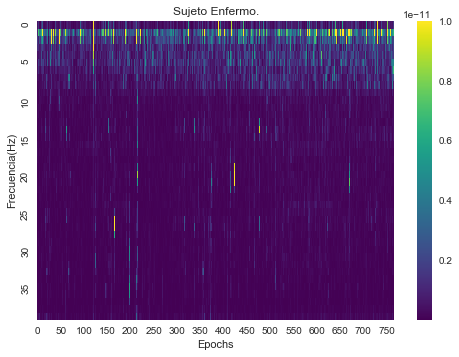

In [147]:
def promedio_frecuencias(sujeto, lista_electrodos, index):
    elect = sujeto[:,lista_electrodos[0]-1,:]
    welch = sp.signal.welch(elect, noverlap=100,fs= 250, nperseg = 201)
    index = (np.abs(welch[0]-50)).argmin()
    potencias = welch[1][:,:index]
    
    for i in range(1, len(lista_electrodos)):
        elect = sujeto[:,lista_electrodos[i]-1,:]
        welch = sp.signal.welch(elect, noverlap=100,fs= 250, nperseg = 201)
        pot_aux = welch[1][:,:index]
        potencias += pot_aux
    potencias = potencias/len(lista_electrodos)
    return (potencias, index)

def graficar_potencia(potencia, enfermo):
    sn.heatmap(np.transpose(S_promedio_potencias), cmap='viridis', vmax=1e-11,  xticklabels = 50, yticklabels=5)
    if enfermo:
        plt.title("Sujeto Enfermo.")
    else:
        plt.title("Sujeto Sano.")
    plt.ylabel("Frecuencia(Hz)")
    plt.xlabel("Epochs")
    plt.show()

index = -1
S_potencia, index = promedio_frecuencias(lista_sujetosS[0],[8, 44, 80, 131, 185], index)

graficar_potencia(S_potencia, False)

P_potencia, index = promedio_frecuencias(lista_sujetosP[0],[8, 44, 80, 131, 185], index)

graficar_potencia(P_potencia, True)



Para poder comparar entre ambas potencias, decidimos restar los valores del sujeto sano y el enfermo(se acorto la dimensión del sujeto enfermo, ya que tenía más epochs que el sujeto sano). Se calcula el valor absoluto ya que al no tomarlo, el espectro no dejaba ver una diferencia clara entre sujetos, Esto tiene una clara desventaja por que no sabemos cual tiene más o menos potencia en un punto.  

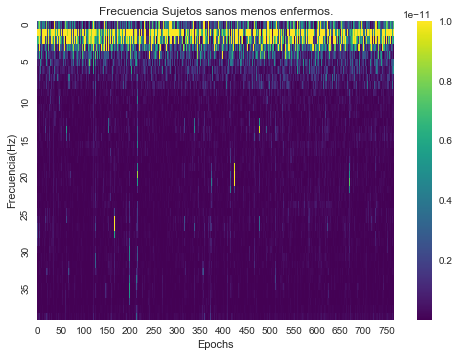

In [148]:
minimo_epochs = min(P_promedio_potencias.shape[0], S_promedio_potencias.shape[0])

P_promedio_potencias = P_promedio_potencias[:minimo_epochs,:]
S_promedio_potencias = S_promedio_potencias[:minimo_epochs,:]
S_P_prom = np.absolute(P_promedio_potencias - S_promedio_potencias);
sn.heatmap(np.transpose(S_P_prom), cmap='viridis',vmax = 1e-11, xticklabels = 50, yticklabels = 5)
plt.ylabel("Frecuencia(Hz)")
plt.xlabel("Epochs")
plt.title("Frecuencia Sujetos sanos menos enfermos.")
plt.show()

Otra forma de mostrar este información es a travez de un gráfico de linea.
En el mismo se representa cada epoch con una linea, en el eje X representamos la frecuencia  y en el Y el promedio de las potencias para ese epoch

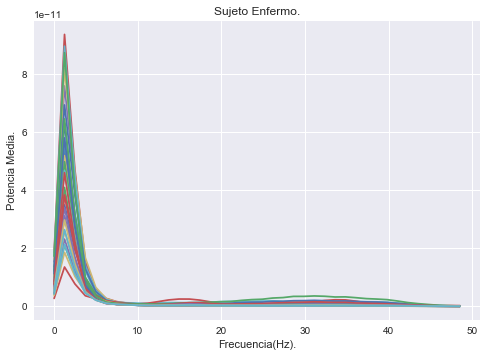

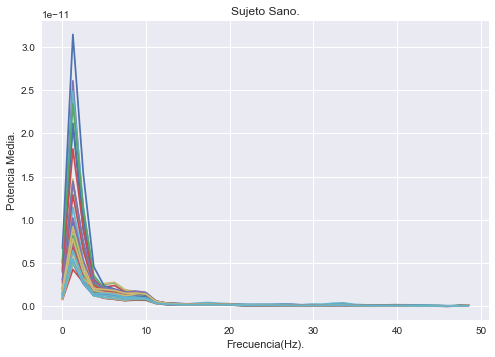

In [149]:
#promedio de potencias de frecuencias por epoch
def grafico_potencia_frecuencia(sujeto, rango, enfermo):
    potencias_media = []
    for count in range(rango):
        welch = sp.signal.welch(sujeto[:,count,:], noverlap=100, fs=250, nperseg = 201)
        frecuencias = welch[0][:index]
        potencias = welch[1][:, :index]
        promedio_potencias = potencias.mean(axis=0)
        P_potencias_media.append(promedio_potencias)
        plt.plot(frecuencias, np.transpose(promedio_potencias))

    plt.xlabel("Frecuencia(Hz).")
    plt.ylabel("Potencia Media.")
    if enfermo:
        plt.title("Sujeto Enfermo.")
    else:
        plt.title("Sujeto Sano.")
    plt.show()

grafico_potencia_frecuencia(lista_sujetosP[0], 30, True)

grafico_potencia_frecuencia(lista_sujetosS[0], 30, False)

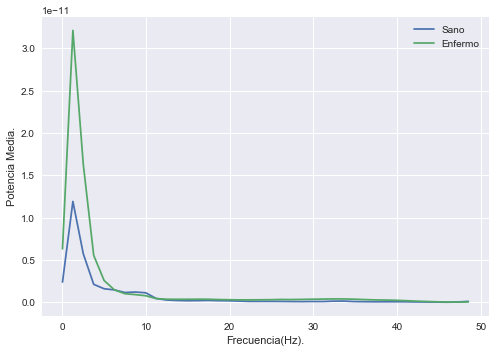

In [150]:
P_potencias_media = np.array(P_potencias_media)
P_medias = P_potencias_media.mean(axis=0)

S_potencias_media = np.array(S_potencias_media)
S_medias = S_potencias_media.mean(axis=0)


plt.plot(frecuencias, S_medias, label = "Sano")
plt.plot(frecuencias, P_medias, label = "Enfermo")
plt.legend()
plt.ylabel("Potencia Media.")
plt.xlabel("Frecuencia(Hz).")
#plt.title("Frecuencia.")
plt.show()   
        
        
    

# b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

In [151]:
#Para los sujetos enfermos
#cuantos electrodos queremos tener en cuenta /se podria pasar una lista con electrodos pre selecionados
cantidad_electrodos = 30
P_pot = calcular_bandas(lista_sujetosP, cantidad_electrodos, False, index)
print(P_pot)


                delta         theta         alpha          beta          gama
sujeto1  8.073636e-11  4.801059e-12  1.689331e-12  6.292932e-12  5.235659e-12
sujeto2  7.885791e-11  5.653144e-12  1.467587e-12  1.000948e-12  3.548564e-13
sujeto3  5.208324e-11  5.937788e-12  1.817280e-12  9.990306e-13  3.381059e-13
sujeto4  5.137965e-11  4.062093e-12  1.350846e-12  1.934666e-12  1.026047e-12
sujeto5  5.851673e-11  1.668007e-11  1.485093e-12  3.334227e-12  1.647675e-12
sujeto6  4.949784e-11  9.752007e-12  1.652113e-12  2.059002e-12  1.043252e-12
sujeto7  6.055293e-11  1.824816e-11  3.423034e-12  3.961061e-12  1.858157e-12
sujeto8  6.297806e-11  4.481956e-12  2.233026e-12  1.381979e-12  2.987897e-13


In [152]:
#Para los sujetos sanos
S_pot = calcular_bandas(lista_sujetosS, cantidad_electrodos, False, index)
print(S_pot)

                delta         theta         alpha          beta          gama
sujeto1  2.008125e-11  3.106035e-12  2.856542e-12  2.246954e-12  1.409650e-12
sujeto2  3.828608e-11  2.423998e-12  1.659783e-11  4.067588e-12  1.584480e-12
sujeto3  1.615492e-11  5.901515e-12  9.695468e-12  3.428125e-12  5.189102e-13
sujeto4  1.694187e-11  2.237660e-12  2.268376e-12  3.882148e-12  2.471544e-12
sujeto5  5.897101e-11  2.533486e-11  3.023585e-11  3.228240e-11  2.288836e-11
sujeto6  2.873541e-11  3.553410e-12  2.426252e-11  3.083918e-12  1.048510e-12
sujeto7  3.011972e-11  2.231760e-12  1.071120e-11  6.019996e-12  3.794738e-12
sujeto8  1.745363e-11  2.311720e-12  1.711761e-11  2.603746e-12  3.642118e-13
sujeto9  1.591073e-11  2.497207e-12  2.179856e-11  3.660682e-12  1.010291e-12


# Categorico

c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.

Suejtos sanos: 


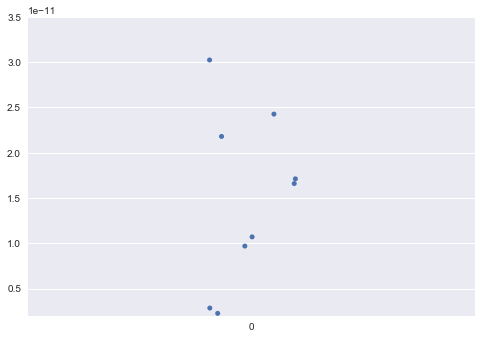

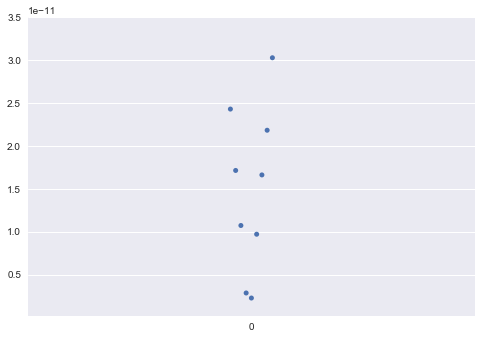

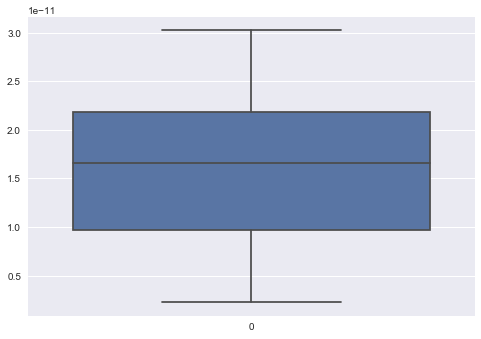

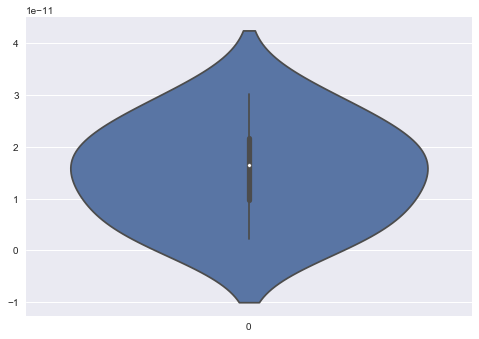

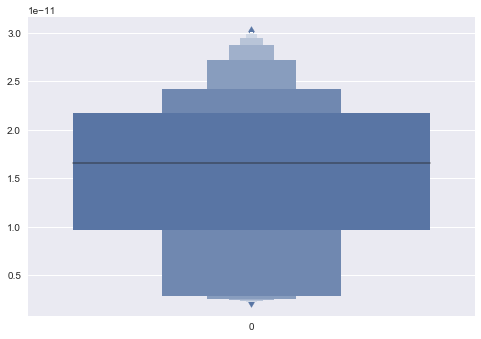

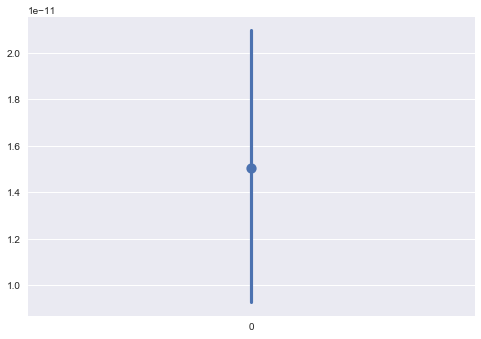

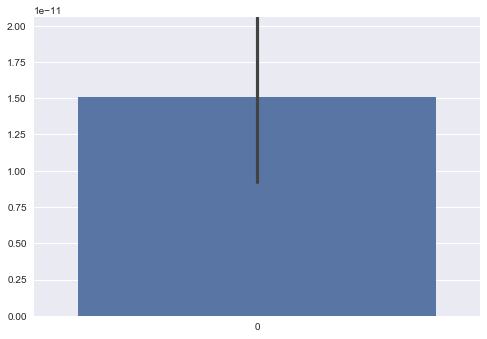

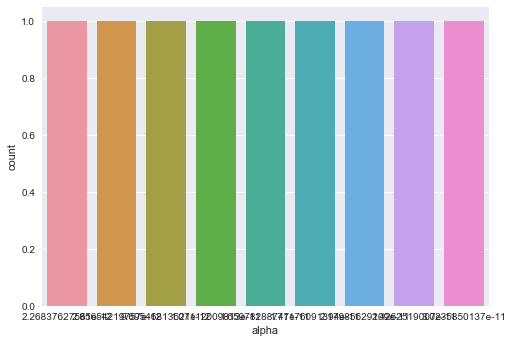

In [153]:

print('Suejtos sanos: ')
sn.stripplot(data=S_pot['alpha'], jitter = True, vmin = 5e-13, vmax =2e-11)
#sn.stripplot(data=df_P_alpha, jitter = True)
plt.ylim(2e-12, 3.5e-11)
plt.show()
sn.swarmplot(data=S_pot['alpha'])
plt.ylim(2e-13, 3.5e-11)
plt.show()
sn.boxplot(data=S_pot['alpha']) 
plt.show()
sn.violinplot(data=S_pot['alpha'])
plt.show()
sn.lvplot(data=S_pot['alpha'])
plt.show()
sn.pointplot(data=S_pot['alpha'])
plt.show()
sn.barplot(data=S_pot['alpha'])
plt.show()
sn.countplot(x=[i for i in range(len(S_pot['alpha']))] ,data=S_pot['alpha'])

plt.show()
print('')

Sujetos enfermos: 


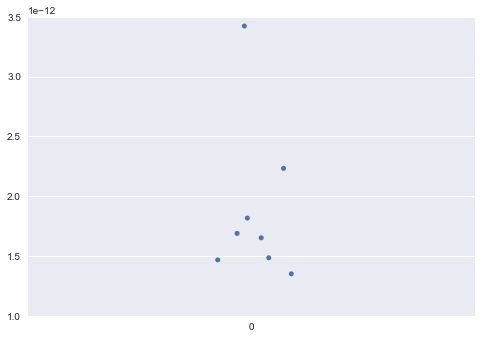

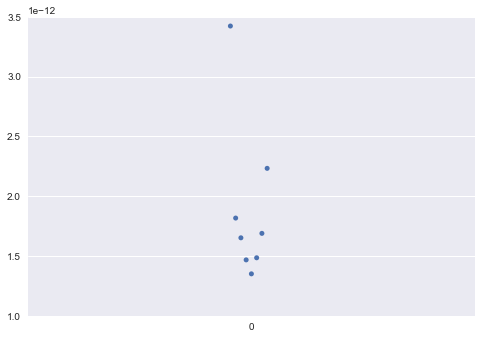

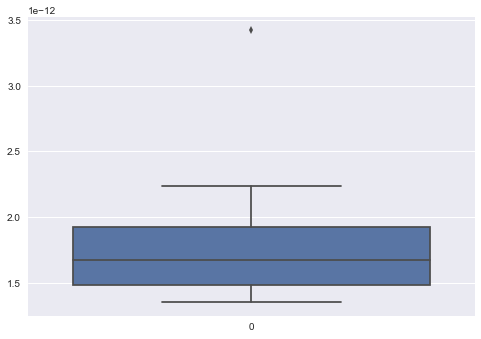

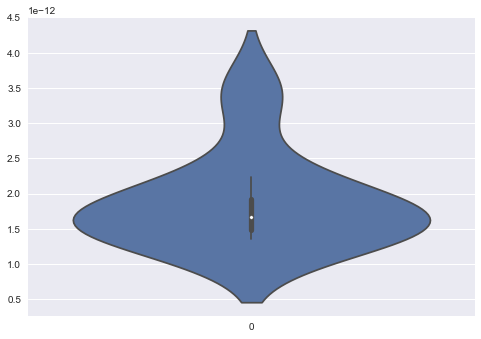

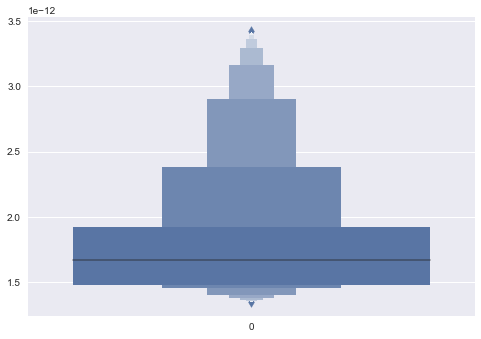

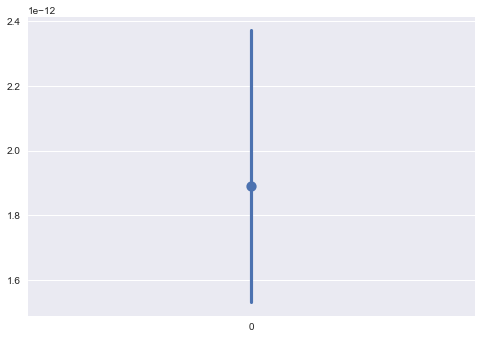

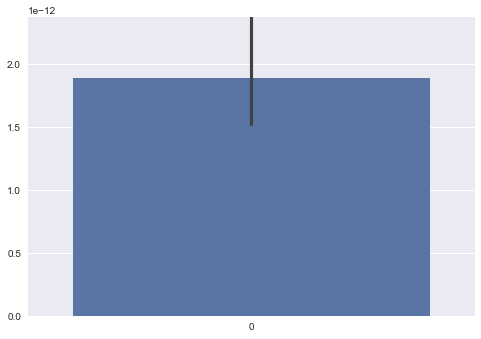

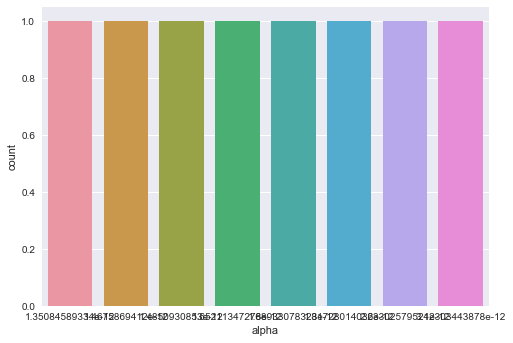

In [154]:

print('Sujetos enfermos: ')
sn.stripplot(data=P_pot['alpha'], jitter = True, vmin = 5e-13, vmax =2e-11)
#sn.stripplot(data=df_P_alpha, jitter = True)
plt.ylim(1e-12, 3.5e-12)
plt.show()
sn.swarmplot(data=P_pot['alpha'])
plt.ylim(1e-12, 3.5e-12)
plt.show()
sn.boxplot(data=P_pot['alpha']) 
plt.show()
sn.violinplot(data=P_pot['alpha'])
plt.show()
sn.lvplot(data=P_pot['alpha'])
plt.show()
sn.pointplot(data=P_pot['alpha'])
plt.show()
sn.barplot(data=P_pot['alpha'])
plt.show()
sn.countplot(x=[i for i in range(len(P_pot['alpha']))] ,data=P_pot['alpha'])

plt.show()
print('')

¿Cuál recomendaría para graficar y comparar distribuciones?

violin plot, ya que no solo nos muestra donde estan los quartiles y si hay algún outlier, como lo hace el box plot, sino que tambien nos muestra como estan distribuidos los puntos. Es decir, las partes mas anchas tienen mayor dencidad de puntos y las mas angostas tienen menos punto. Esto nos deja observar mucho mejor el espacio de muestra y como se distribuye en el espacio.

# d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

## Pacientes P

violin plot para todas las bandas


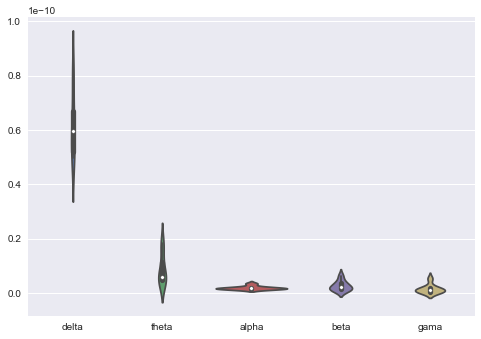

violin plot para alpha


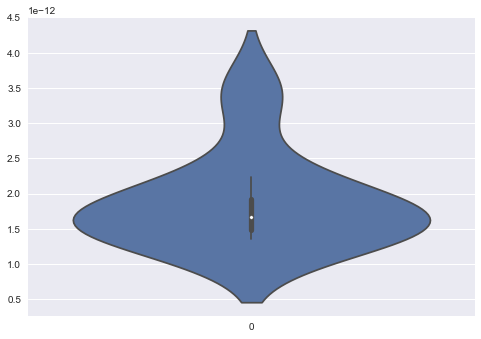

violin plot para beta


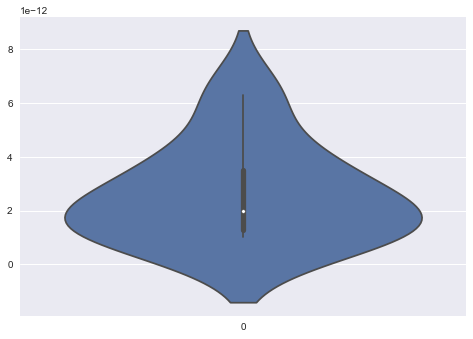

violin plot para theta


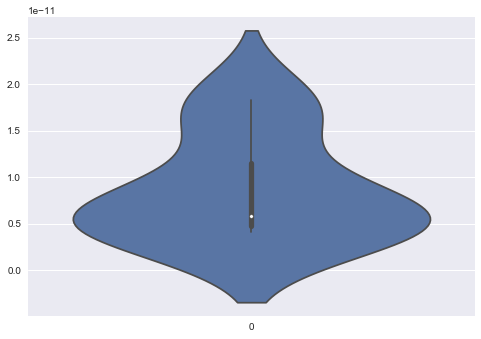

violin plot para delta


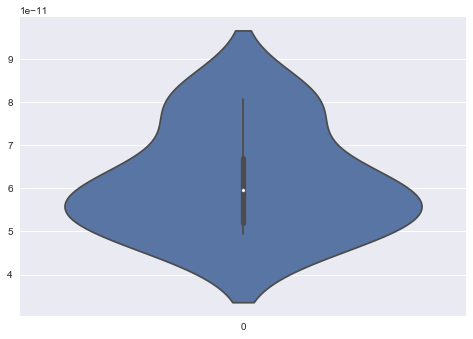

violin plot para gama


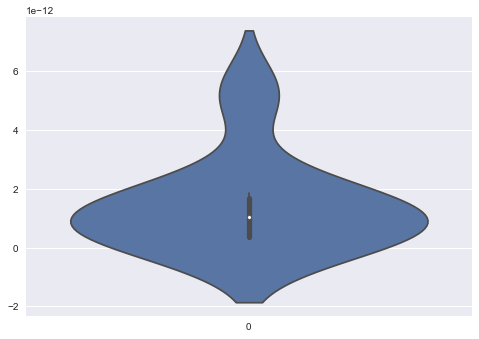

In [155]:
print('violin plot para todas las bandas')
sn.violinplot(data=P_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=P_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=P_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=P_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=P_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=P_pot['gama'])
plt.show()

## Pacientes S

violin plot para todas las bandas


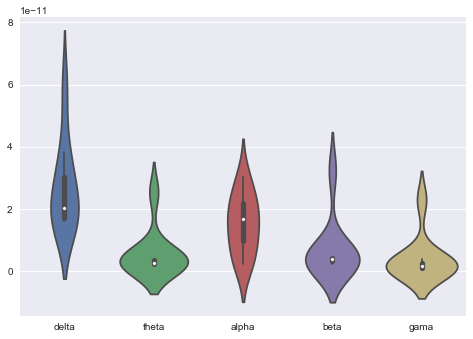

violin plot para alpha


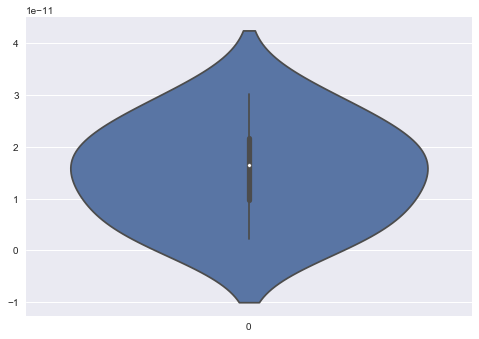

violin plot para beta


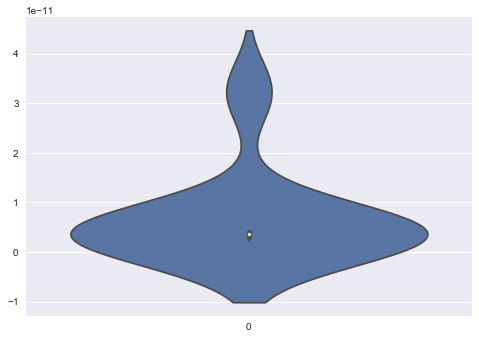

violin plot para theta


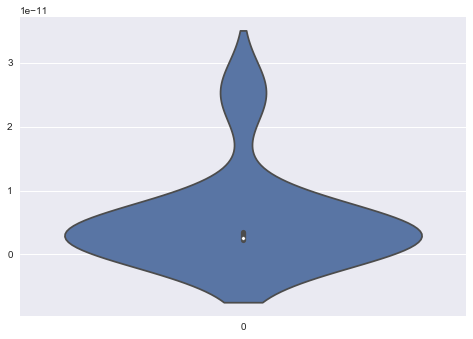

violin plot para delta


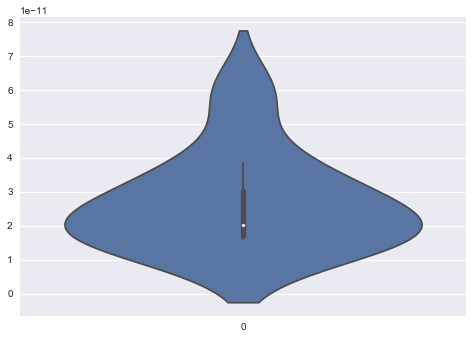

violin plot para gama


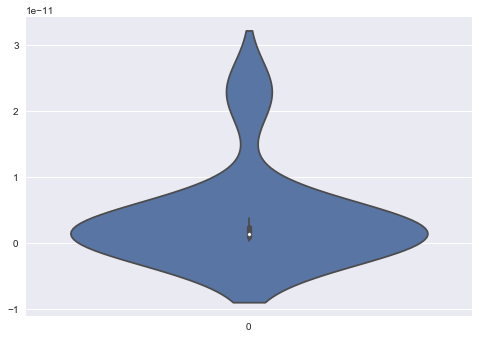

In [156]:
print('violin plot para todas las bandas')
sn.violinplot(data=S_pot)
plt.show()

print('violin plot para alpha')
sn.violinplot(data=S_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=S_pot['beta'])
plt.show()
print('violin plot para theta')    
sn.violinplot(data=S_pot['theta'])
plt.show()
    
print('violin plot para delta')    
sn.violinplot(data=S_pot['delta'])
plt.show()

print('violin plot para gama')
sn.violinplot(data=S_pot['gama'])
plt.show()

## Test Estadístico d)

#### Idea: Tomamos la banda gamma y queremos ver si dos pacientes tienen la misma media. la banda gama por cada paciente es e l promedio de todos sus epochs.

In [157]:
gama = tomar_banda(lista_sujetosS, 'gama', index)

igual_media_apareada(gama['sujeto1'],gama['sujeto2'])

checkeo distribución normal: No concluyente, suponemos normalidad
checkeo varianza: No concluyente, suponemos igual varianza
utilizamos test de Student
p value = 0.250153985307
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.191446403571


No podemos concluir nada ya que nuestro p valor no fue lo suficientemente chico.

# e) Repetir los puntos b) y d) para los valores normalizados.

## Pacientes Enfermos

In [158]:

#Para los sujetos enfermos
cantidad_electrodos = 30
P_pot = calcular_bandas(lista_sujetosP, cantidad_electrodos, True, index)

print(P_pot)




                delta         theta         alpha          beta          gama
sujeto1  2.691212e-11  2.400529e-12  5.631103e-13  4.840717e-13  3.490439e-13
sujeto2  2.628597e-11  2.826572e-12  4.891956e-13  7.699603e-14  2.365710e-14
sujeto3  1.736108e-11  2.968894e-12  6.057600e-13  7.684851e-14  2.254039e-14
sujeto4  1.712655e-11  2.031046e-12  4.502820e-13  1.488205e-13  6.840312e-14
sujeto5  1.950558e-11  8.340033e-12  4.950310e-13  2.564790e-13  1.098450e-13
sujeto6  1.649928e-11  4.876003e-12  5.507045e-13  1.583847e-13  6.955014e-14
sujeto7  2.018431e-11  9.124081e-12  1.141011e-12  3.046970e-13  1.238772e-13
sujeto8  2.099269e-11  2.240978e-12  7.443419e-13  1.063061e-13  1.991931e-14


violin plot para todas las bandas


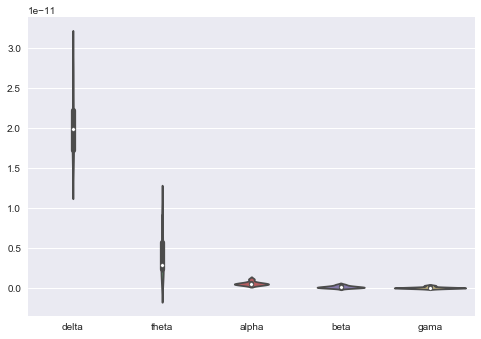

violin plot para alpha


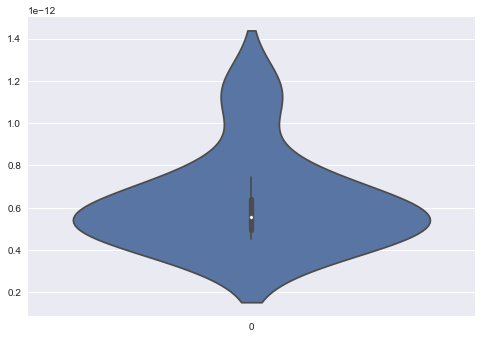

violin plot para beta


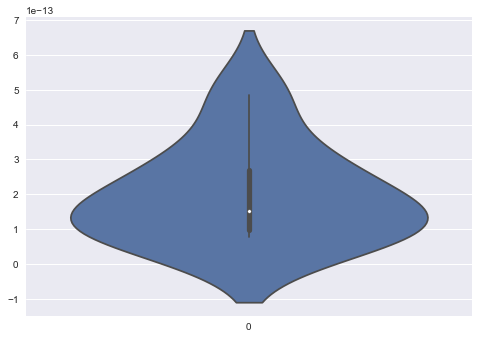

violin plot para theta


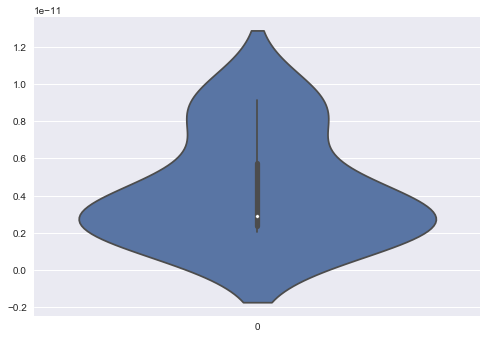

violin plot para delta


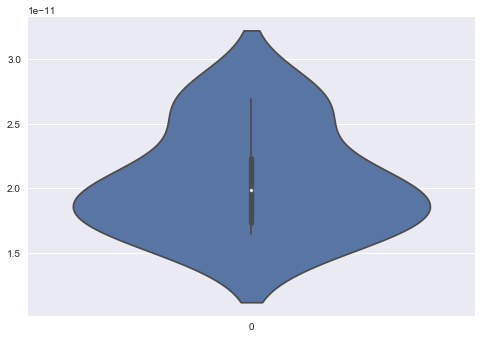

violin plot para gama


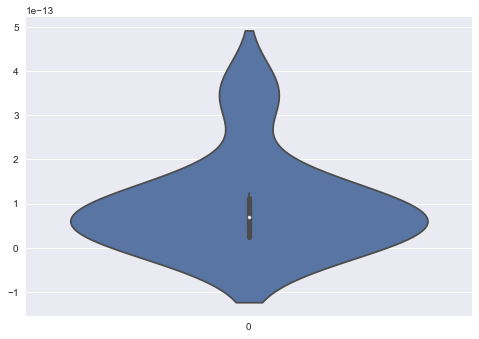

In [159]:
print('violin plot para todas las bandas')
sn.violinplot(data=P_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=P_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=P_pot['beta'])
plt.show()

print('violin plot para theta')    
sn.violinplot(data=P_pot['theta'])
plt.show()

print('violin plot para delta')    
sn.violinplot(data=P_pot['delta'])
plt.show()
 
print('violin plot para gama')
sn.violinplot(data=P_pot['gama'])
plt.show()

### Test estadístico

In [160]:

igual_media_apareada(P_pot['beta'],P_pot['gama'])

utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.0117186855998


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Podemos observar que el test de Wilcoxon nos da un pvalor muy bajo rechazando la hipótesis nula es decir que beta y alpha no tienen la misma media.

## Pacientes sanos

In [161]:
#Para los sujetos sanos
S_pot = calcular_bandas(lista_sujetosS, cantidad_electrodos, False, index)

print(S_pot)

                delta         theta         alpha          beta          gama
sujeto1  2.008125e-11  3.106035e-12  2.856542e-12  2.246954e-12  1.409650e-12
sujeto2  3.828608e-11  2.423998e-12  1.659783e-11  4.067588e-12  1.584480e-12
sujeto3  1.615492e-11  5.901515e-12  9.695468e-12  3.428125e-12  5.189102e-13
sujeto4  1.694187e-11  2.237660e-12  2.268376e-12  3.882148e-12  2.471544e-12
sujeto5  5.897101e-11  2.533486e-11  3.023585e-11  3.228240e-11  2.288836e-11
sujeto6  2.873541e-11  3.553410e-12  2.426252e-11  3.083918e-12  1.048510e-12
sujeto7  3.011972e-11  2.231760e-12  1.071120e-11  6.019996e-12  3.794738e-12
sujeto8  1.745363e-11  2.311720e-12  1.711761e-11  2.603746e-12  3.642118e-13
sujeto9  1.591073e-11  2.497207e-12  2.179856e-11  3.660682e-12  1.010291e-12


violin plot para todas las bandas


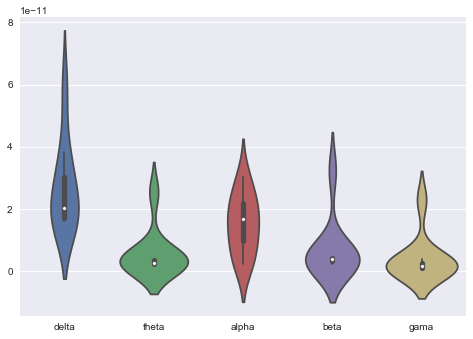

violin plot para alpha


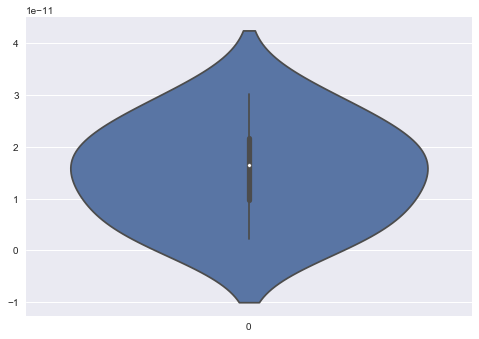

violin plot para beta


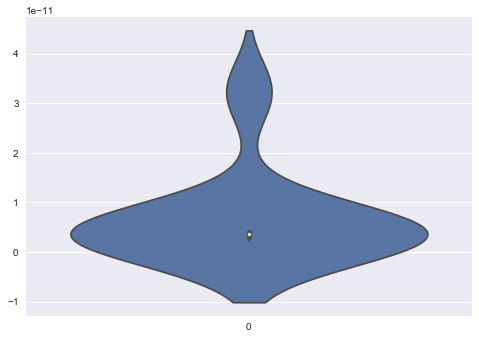

violin plot para theta


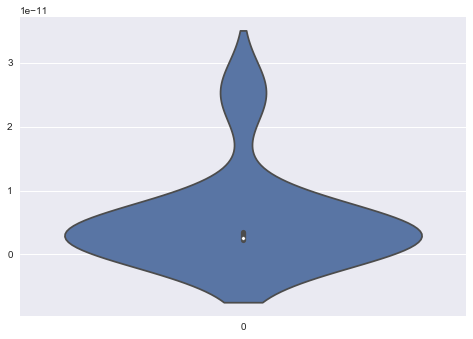

violin plot para delta


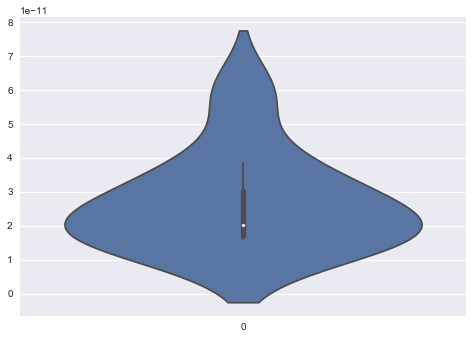

violin plot para gama


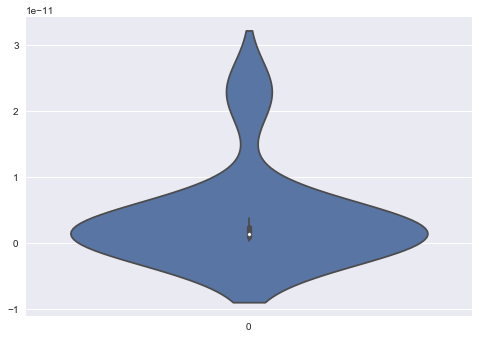

In [162]:

print('violin plot para todas las bandas')
sn.violinplot(data=S_pot)
plt.show()
print('violin plot para alpha')
sn.violinplot(data=S_pot['alpha'])
plt.show()

print('violin plot para beta')
sn.violinplot(data=S_pot['beta'])
plt.show()
#igual_media_1muestra(beta)

print('violin plot para theta')    
sn.violinplot(data=S_pot['theta'])
plt.show()
#print("muy pocos datos para llegar a una conclusión")
#igual_media_1muestra(theta)
    
print('violin plot para delta')    
sn.violinplot(data=S_pot['delta'])
plt.show()
#igual_media_1muestra(delta)
 
print('violin plot para gama')
sn.violinplot(data=S_pot['gama'])
plt.show()

### Test estadístico

In [163]:
igual_media_apareada(P_pot['beta'],P_pot['gama'])

utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.0117186855998


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Podemos observar que el test de Wilcoxon nos da un pvalor muy bajo rechazando la hipótesis nula es decir que beta y alpha no tienen la misma media.

# Ejer 2.2


funciones auxiliares para medida de informacion inter-electrodo.

In [164]:
def eleccion_n(x):
    res = (x.max()-x.min())/(3.5*x.std()*len(x)**(-1/3))
    return int(res)

def entropia(sujeto, electrodo):
    x = promediar_epoch(sujeto, electrodo)
    bins = eleccion_n(x)
    counts_x, bins = np.histogram(x, bins=bins)
    return sp.stats.entropy(counts_x)

def entropia_total(lista_sujetos, cant_electrodos):
    df = pd.DataFrame()
    for j in range(cant_electrodos):
        aux = []
        for sujeto in lista_sujetos:
            aux.append(entropia(sujeto, j))
        df["e"+str(j+1)]  = aux
    return df
    
def mutual_information_total(lista_sujetos, electrodo1, electrodo2):
    df = pd.DataFrame()
    aux = []
    for i in range(len(lista_sujetos)):
        
        for j in range(i,len(lista_sujetos)):
            aux.append(mutual_information(lista_sujetos[i], electrodo1, lista_sujetos[j], electrodo2))
    df = aux
    return df

def mutual_information(sujeto1, electrodo1, sujeto2, electrodo2):
    x = promediar_epoch(sujeto1, electrodo1)
    y = promediar_epoch(sujeto2, electrodo2)
    bins_x = eleccion_n(x)
    bins_y = eleccion_n(y)
    bins = min(bins_x, bins_y)
    counts_xy, bins_x, bins_y = np.histogram2d(x, y, bins=(bins, bins))
    counts_x, bins = np.histogram(x, bins=bins)
    counts_y, bins = np.histogram(y, bins=bins)

    counts_xy += 1
    counts_x += 1
    counts_y += 1
    P_xy = counts_xy / np.sum(counts_xy, dtype=float)
    P_x = counts_x / np.sum(counts_x, dtype=float)
    P_y = counts_y / np.sum(counts_y, dtype=float)

    I_xy = np.sum(P_xy * np.log2(P_xy / (P_x.reshape(-1, 1) * P_y)))

    return I_xy / (sp.stats.entropy(counts_x) + sp.stats.entropy(counts_y))

## 2.2 
### a) Computar una medida de información intra-electrodo. 

In [165]:
#entropia (intra-elect) para el electrodo 8(de un P) 
P_Media8 = promediar_epoch(lista_sujetosP[0], 8)
P_Media44 =promediar_epoch(lista_sujetosP[0], 44)

P_entropia_8 = entropia(lista_sujetosP[0], 8)
print(P_entropia_8)

print(mutual_information(lista_sujetosP[0], 8, lista_sujetosP[0], 44))

1.48900355197
0.436172851299


 
## a)Calcular la media (de las medidas intra) entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

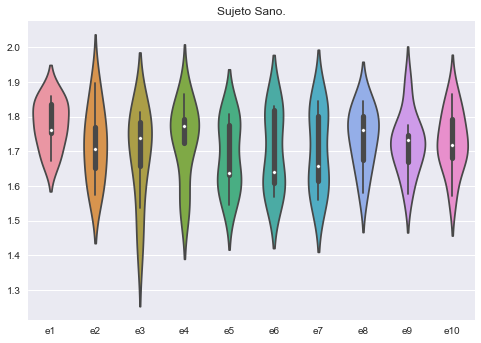

In [166]:

S_entropia = entropia_total(lista_sujetosS, 10)
sn.violinplot(data=S_entropia)
plt.title("Sujeto Sano.")
plt.show()

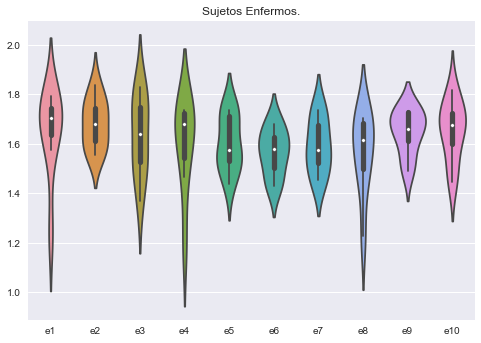

In [167]:
P_entropia = entropia_total(lista_sujetosP, 10)
sn.violinplot(data=P_entropia)
plt.title("Sujetos Enfermos.")
plt.show()

### Test estadístico

#### al ver los violin plots, nos apreciamos que el electrodo 6 y 7 del conjunto de sanos son muy similares, por eso decidimos testear si ellos tienen la misma media.

In [168]:
igual_media_apareada(S_entropia['e6'],S_entropia['e7'])

checkeo distribución normal: No concluyente, suponemos normalidad
checkeo varianza: No concluyente, suponemos igual varianza
utilizamos test de Student
p value = 0.881637424975
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.441268133329


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


No se puede concluir nada, ya que los pvalores son muy altos.

## b) Repetir el punto a) para una medida inter-electrodo.

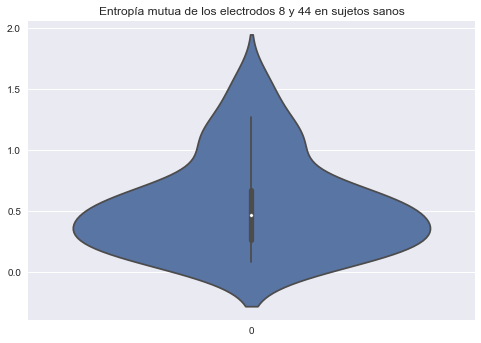

In [169]:
S_44_8 = mutual_information_total(lista_sujetosS, 8, 44)
sn.violinplot(data=S_44_8)
plt.title("Entropía mutua de los electrodos 8 y 44 en sujetos sanos")
plt.show()

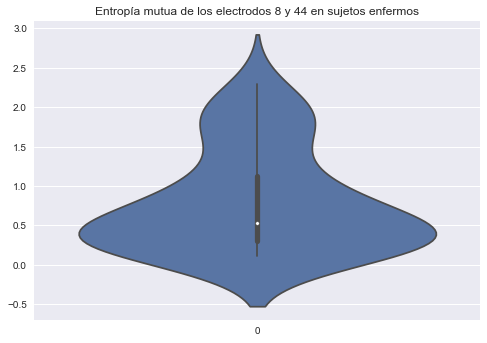

In [170]:
P_44_8 = mutual_information_total(lista_sujetosP, 8, 44)
sn.violinplot(data=P_44_8)
plt.title("Entropía mutua de los electrodos 8 y 44 en sujetos enfermos")
plt.show()

In [171]:
mini = min(len(P_44_8), len(S_44_8))
S_44_8 = S_44_8[:mini]
P_44_8 = P_44_8[:mini]
igual_media_apareada(S_44_8,P_44_8)

utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.123649021453


el p valor es muy alto como para rechazar la hipótesis nula.